In [1]:
import os
import numpy as np
from osgeo import gdal

%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (15, 10)
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from skimage import exposure


from tensorflow.keras.optimizers import SGD, Adadelta, Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import ZeroPadding2D, Convolution2D, MaxPooling2D, Activation, BatchNormalization, Reshape
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import SGD, Adadelta
from tensorflow.keras.layers import LeakyReLU
import tensorflow as tf
from tensorflow import keras

# from keras.backend.tensorflow_backend import set_session
# from tensorflow.compat.v1.keras.backend import set_session
# config = tf.compat.v1.ConfigProto()
# config.gpu_options.per_process_gpu_memory_fraction = 0.2
# set_session(tf.Session(config=config))

# import gim_cv.datasets as datasets

Populating the interactive namespace from numpy and matplotlib


In [2]:
# # define dataset directory
# BASE_PATH = '/home/root/TRAIN/fullset/'
# IMAGE_PATH = os.path.join(BASE_PATH, "raw_image")
# LABEL_PATH = os.path.join(BASE_PATH, "ground_truth")

Populating the interactive namespace from numpy and matplotlib


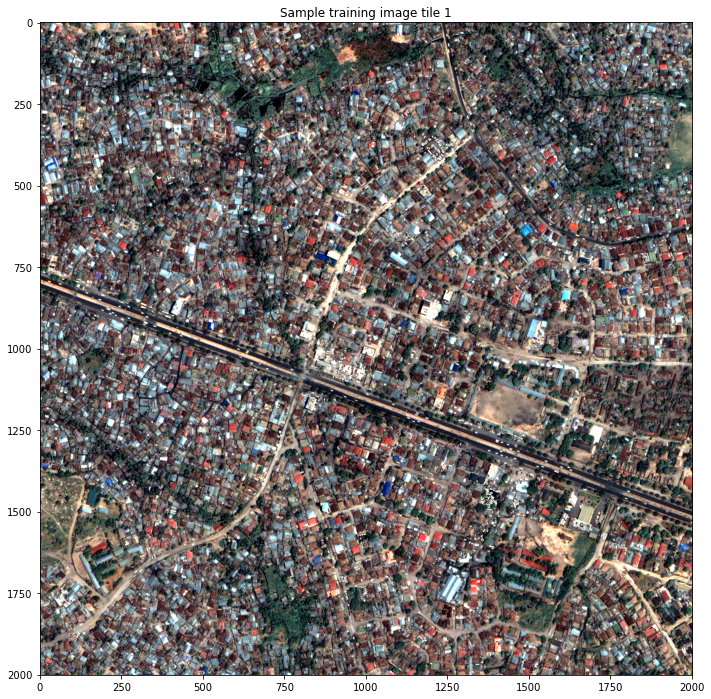

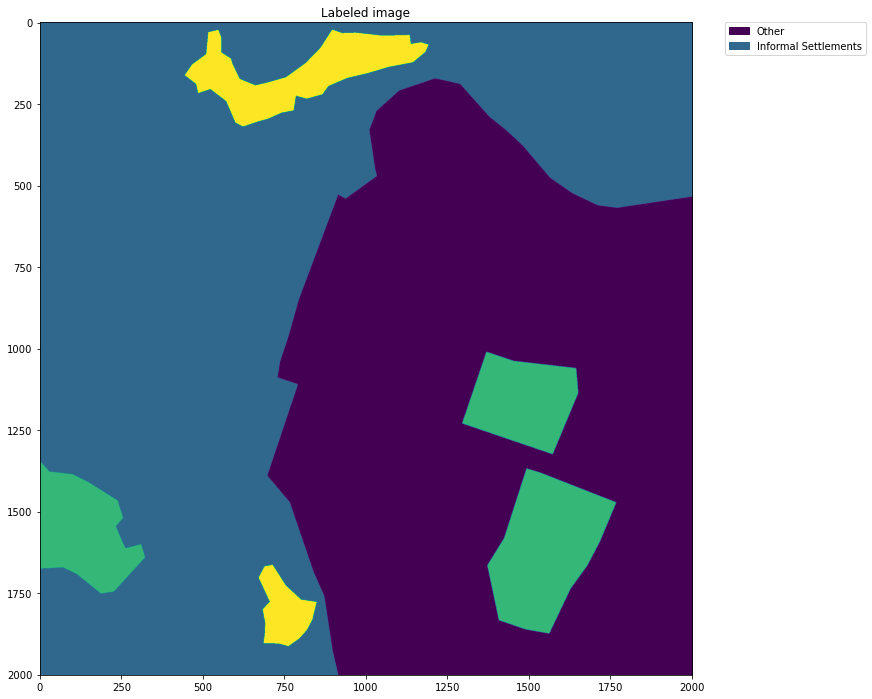

In [45]:
import os
import numpy as np
from osgeo import gdal
import tensorflow.keras
%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (15, 10)
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from skimage import exposure

# define dataset directory
BASE_PATH = '/home/root/TRAIN/fullset/'
IMAGE_PATH = os.path.join(BASE_PATH, "raw_image")
LABEL_PATH = os.path.join(BASE_PATH, "ground_truth")

def gtiff_to_array(file_path):
    """Takes a file path and returns a tif file as a 3-dimensional numpy array, width x height x bands."""
    data = gdal.Open(file_path)
    bands = [data.GetRasterBand(i+1).ReadAsArray() for i in range(data.RasterCount)]
    return np.stack(bands, axis=2)


def fetch_tiles(path):
    """Parse the images into a dictionary of numpy arrays.
    
    The following keys are used:
    sat -- satellite image
    bldg -- for the building locations reference image
    road -- for the road locations reference image
    """
    tiles = {}
    for f in sorted(os.listdir(path)):
        fdir = os.path.join(path, f)
        _, ext = os.path.splitext(f)
        if ext.lower() == ".tif":
            imgtype = f[-9:-4]
            tiles[imgtype] = gtiff_to_array(fdir)
    return tiles


def visualize_labels(labels, fig_width=15, fig_height=12):
    """Visualize the labels prepared from the reference images."""
    fig = plt.figure(figsize=(fig_width, fig_height))
    a=fig.add_subplot(1,1,1)
    values = np.unique(labels.ravel())
    im = plt.imshow(labels[:,:,0])
    a.set_title("Labeled image")
    # get the colors of the values, according to the 
    # colormap used by imshow
    colors = [im.cmap(im.norm(value)) for value in values]
    # create a patch (proxy artist) for every color 
    labels = ["Other", "Informal Settlements"]
    patches = [mpatches.Patch(color=colors[i], label=j) for i, j in zip(range(len(values)), labels)]
    # put those patched as legend-handles into the legend
    plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0. )


def visualize_data(data, title, fig_width=15, fig_height=12):
    """Visualize the satellite image data."""
    # visualize only RGB bands
    data = data[:, :, 0:-1]
    _ = data[:, :, 0].copy()
    data[:, :, 0] = data[:, :, 2]
    data[:, :, 2] = _
    data = data.astype(np.float)
    # perform stretching for better visualization
    for i in range(data.shape[2]):
        p2, p98 = np.percentile(data[:, :, i], (2, 98))
        data[:, :, i] = exposure.rescale_intensity(data[:, :, i],
                                                      in_range=(p2, p98))
    fig = plt.figure(figsize=(fig_width, fig_height))
    a=fig.add_subplot(1,1,1)
    a.set_title(title)
    plt.imshow(data)

    
image_tiles = fetch_tiles(IMAGE_PATH)
label_tiles = fetch_tiles(LABEL_PATH)

visualize_data(image_tiles["area7"], "Sample training image tile 1")
visualize_labels(label_tiles["area7"])

In [53]:
PATCHSIZE = 128
NBANDS = image_tiles["area1"].shape[-1]

def gridwise_sample(imgarray, patchsize):
    """Extract sample patches of size patchsize x patchsize from an image (imgarray) in a gridwise manner.
    """
    nrows, ncols, nbands = imgarray.shape
    patchsamples = np.zeros(shape=(0, patchsize, patchsize, nbands),
                            dtype=imgarray.dtype)
    for i in range(int(nrows/patchsize)):
        for j in range(int(ncols/patchsize)):
            tocat = imgarray[i*patchsize:(i+1)*patchsize,
                             j*patchsize:(j+1)*patchsize, :]
            tocat = np.expand_dims(tocat, axis=0)
            patchsamples = np.concatenate((patchsamples, tocat),
                                          axis=0)
    return patchsamples

Xtrain = np.zeros(shape=(0, PATCHSIZE, PATCHSIZE, NBANDS), dtype=np.float32)
Ytrain = np.zeros(shape=(0, PATCHSIZE, PATCHSIZE, 1), dtype=np.uint8)
# sample each training tile systematically in a gridwise manner
train_areas = ["area1", "area2", "area3"]
for area in train_areas:
    X_toadd = gridwise_sample(image_tiles[area], PATCHSIZE)
    Y_toadd = gridwise_sample(label_tiles[area], PATCHSIZE)
    Xtrain = np.concatenate((Xtrain, X_toadd), axis=0)
    Ytrain = np.concatenate((Ytrain, Y_toadd), axis=0)
# encode all non-informal settlement classes as one class
Ytrain[Ytrain!=2] = 1
print("There are %i number of training patches" % (Xtrain.shape[0]))
print(Xtrain.shape)

There are 675 number of training patches
(675, 128, 128, 4)


In [54]:

def to_categorical_4d(y, nc):
    """Convert a reclassed ground truth array to one-hot encoding
    
    Keyword arguments:
    y -- ground truth image
    nc -- number of classes
    """
    Y = np.zeros((y.shape[0],
                  y.shape[1],
                  y.shape[2],
                  nc),
                  dtype=np.int32)
    for h in range(y.shape[0]):
        for i in range(y.shape[1]):
            for j in range(y.shape[2]):
                if y[h, i, j, 0] != 0:
                    Y[h, i, j, y[h, i, j, 0]-1] = 1
                else:
                    continue
    return Y

def build_FCNDK6(optimizer, nrows, ncols, nbands, nclasses):
    """Model builder function for FCN-DK6."""
    model = keras.models.Sequential()
    model.add(ZeroPadding2D((2, 2), input_shape=(nrows, ncols, nbands)))
    model.add(Convolution2D(
              filters=16,
              kernel_size=(5, 5),
              dilation_rate=(1, 1)))
    model.add(BatchNormalization(axis=3))
    model.add(LeakyReLU(0.1))
    model.add(ZeroPadding2D((2, 2)))
    model.add(MaxPooling2D(
              pool_size=(5, 5),
              strides=(1, 1)
    ))
    model.add(ZeroPadding2D((4, 4)))
    model.add(Convolution2D(
              filters=32,
              kernel_size=(5, 5),
              dilation_rate=(2, 2)
    ))
    model.add(BatchNormalization(axis=3))
    model.add(LeakyReLU(0.1))
    model.add(ZeroPadding2D((4, 4)))
    model.add(MaxPooling2D(
            pool_size=(9, 9),
            strides=(1, 1)
    ))
    model.add(ZeroPadding2D((6, 6)))
    model.add(Convolution2D(
              filters=32,
              kernel_size=(5, 5),
              dilation_rate=(3, 3)
    ))
    model.add(BatchNormalization(axis=3))
    model.add(LeakyReLU(0.1))
    model.add(ZeroPadding2D((6, 6)))
    model.add(MaxPooling2D(
            pool_size=(13, 13),
            strides=(1, 1)
    ))
    model.add(ZeroPadding2D((8, 8)))
    model.add(Convolution2D(
              filters=32,
              kernel_size=(5, 5),
              dilation_rate=(4, 4)
    ))
    model.add(BatchNormalization(axis=3))
    model.add(LeakyReLU(0.1))
    model.add(ZeroPadding2D((8, 8)))
    model.add(MaxPooling2D(
            pool_size=(17, 17),
            strides=(1, 1)
    ))
    model.add(ZeroPadding2D((10, 10)))
    model.add(Convolution2D(
              filters=32,
              kernel_size=(5, 5),
              dilation_rate=(5, 5)
    ))
    model.add(BatchNormalization(axis=3))
    model.add(LeakyReLU(0.1))
    model.add(ZeroPadding2D((10, 10)))
    model.add(MaxPooling2D(
            pool_size=(21, 21),
            strides=(1, 1)
    ))
    model.add(ZeroPadding2D((12, 12)))
    model.add(Convolution2D(
              filters=32,
              kernel_size=(5, 5),
              dilation_rate=(6, 6)
    ))
    model.add(BatchNormalization(axis=3))
    model.add(LeakyReLU(0.1))
    model.add(ZeroPadding2D((12, 12)))
    model.add(MaxPooling2D(
            pool_size=(25, 25),
            strides=(1, 1)
    ))
    model.add(Convolution2D(
              filters=nclasses,
              kernel_size=(1, 1)
    ))
    model.add(keras.layers.Activation(
              activation="softmax"
    ))
    model.compile(loss="categorical_crossentropy", metrics=['accuracy'], optimizer=optimizer)
    return model

def train(model, data, labels):
    hist = model.fit(x=data,
                     y=labels,
                     epochs=NUMBER_EPOCHS,
                     verbose=2
                    )
    return hist

In [62]:
log = logging.getLogger()
if True:
    # 
    assert tf.config.list_physical_devices('GPU'), "CHECK GPU AVAILABILITY! (eg /etc/docker/daemon.json default runtime)"
    
    # transform target arrays to one-hot encodings
    NUMBER_BANDS = 4
    NUMBER_CLASSES = 2
    NUMBER_EPOCHS = 50
    NCLASS = 2
    PATCHSIZE = 128
    
    
    Ytrain = to_categorical_4d(Ytrain, 2)

    # model definition
    OPT = Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, amsgrad=False)
#     OPT = SGD(lr=0.0001, momentum=0.9)
    fcn = build_FCNDK6(OPT, PATCHSIZE, PATCHSIZE, NUMBER_BANDS, NCLASS)
    # model training
    history = train(fcn, Xtrain, Ytrain)
    # plot learning curve
    plt.plot(history.history["loss"])
    plt.title("Sample net training curve loss")
    plt.ylabel("loss")
    plt.xlabel("epoch")
    plt.show()
    plt.plot(1-np.array(history.history["accuracy"]))
    plt.title("Sample net training curve error rate")
    plt.ylabel("error rate")
    plt.xlabel("epoch")
    plt.show()

Epoch 1/50
22/22 - 8s - loss: 0.3828 - accuracy: 0.6139
Epoch 2/50
22/22 - 8s - loss: 0.1050 - accuracy: 0.9475
Epoch 3/50
22/22 - 8s - loss: 0.0587 - accuracy: 0.9843
Epoch 4/50
22/22 - 8s - loss: 0.0380 - accuracy: 0.9951
Epoch 5/50


KeyboardInterrupt: 

In [8]:
import pickle
# with open('FCN_dar_train_history', 'wb') as file_pi:
#     pickle.dump(history.history, file_pi)
    
# # save the trained network
# import imp, h5py
# imp.reload(h5py)
# model_fname = "dar_trained_fcn_test.hdf5"
# fcn.save(model_fname)

In [9]:
def evaluate_predictions(Xtest, w8fname,
                         cut, overlap, Ytest,
                         model_builder):
    """
    Function to predict full tiles strip-wise (as loading whole tiles might not fit in the memory).
    """
    Ytest = Ytest.copy()
    Ytest[Ytest!=2] = 0
    Ytest[Ytest==2] = 1
    ncols, nrows, nbands = Xtest.shape
    Xtest = np.expand_dims(Xtest, axis=0)
    total_map = np.zeros((nrows, ncols), dtype=np.uint8)
    first = True
    last = False
    if nrows%cut==0:
        numstrips = int(nrows/cut)
    else:
        numstrips = int(nrows/cut) + 1
    for i in range(numstrips):
        print("Strip number: %d" % i)
        if first:
            striptop = 0
            stripbottom = overlap
            height = cut
            X_sub = Xtest[:, cut*i-striptop:(cut*i)+height+stripbottom, :, :]
            first = False
        elif (not first) and (cut*(i+1)+1+overlap < nrows):
            striptop = overlap
            stripbottom = overlap
            height = cut
            X_sub = Xtest[:, cut*i-striptop:(cut*i)+height+stripbottom, :, :]
        else:
            print("Last hit!")
            striptop = overlap
            stripbottom = 0
            height = nrows - cut*i
            if (striptop+height)%(4)!=0:
                height = height*4
            X_sub = Xtest[:, -(striptop+height):, :, :]
            last = True        
        sub_nrows = X_sub.shape[1]
        sub_ncols = X_sub.shape[2]
        model = model_builder(OPT, sub_nrows, sub_ncols, nbands, NUMBER_CLASSES)
        model.load_weights(w8fname)
        sub_ns, sub_nb, _, __ = X_sub.shape
        cmap = model.predict_on_batch([X_sub])
        cmap = np.argmax(cmap[0], axis=2)
        if not last:
            total_map[cut*i:cut*i+height, :] = cmap[striptop:striptop+height, 0:total_map.shape[1]]
        else:
            total_map[-(height):, :] = cmap[-(height):, 0:total_map.shape[1]]
    return total_map

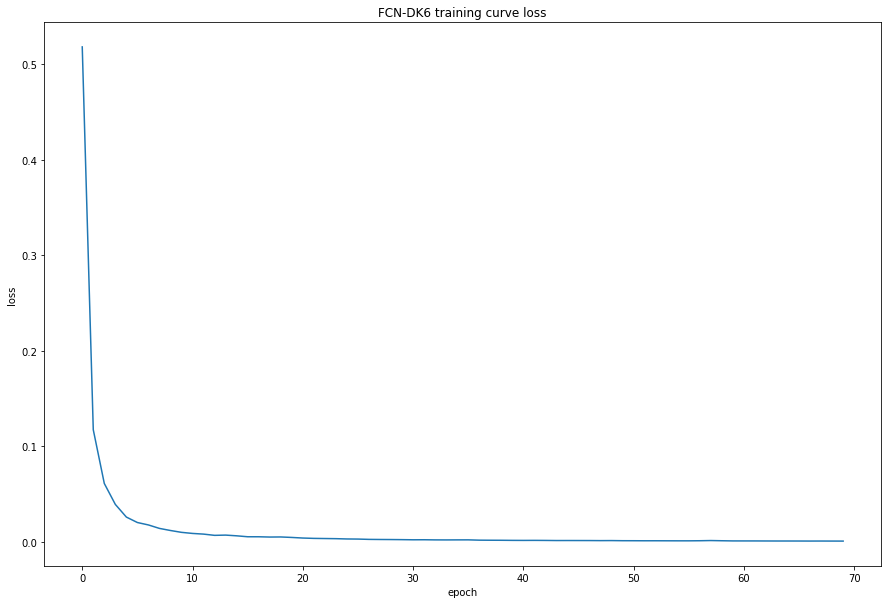

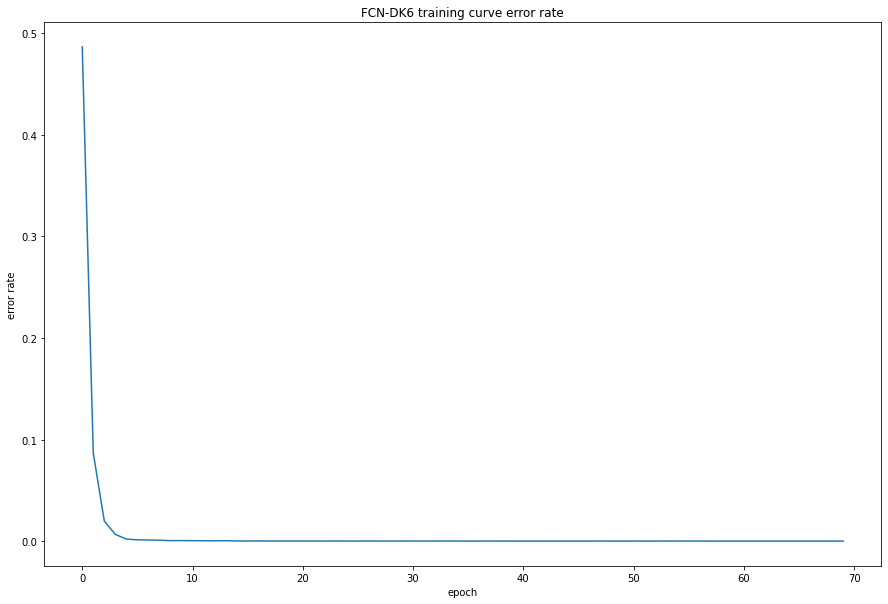

Strip number: 0
Strip number: 1
Strip number: 2
Strip number: 3
Strip number: 4
Strip number: 5
Strip number: 6
Strip number: 7
Strip number: 8
Strip number: 9
Strip number: 10
Strip number: 11
Strip number: 12
Strip number: 13
Strip number: 14
Last hit!
Strip number: 15
Last hit!


In [49]:
#############
# FCN-
#############
# test tile 4
Xtest = image_tiles["area5"]
# Xtest= Xtest[:,:,[0,2,3]]
# print("Xtest", Xtest.shape)
Ytest = label_tiles["area5"]

train_history_B = "FCN_dar_train_history"
weights_pretrained_B = "dar_trained_fcn.hdf5"
# let's visualize the learning curve of the pre-trained network
with open(train_history_B, "rb") as f:
    FCN_DK6_history = pickle.load(f)
plt.plot(FCN_DK6_history["loss"])
plt.title("FCN-DK6 training curve loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.show()
plt.plot(1-np.array(FCN_DK6_history["accuracy"]))
plt.title("FCN-DK6 training curve error rate")
plt.ylabel("error rate")
plt.xlabel("epoch")
plt.show()
# now let's evaluate it on the test tile
cut = 128
overlap = 86
predictions_FCNDK6 = evaluate_predictions(Xtest, weights_pretrained_B, cut, overlap, Ytest, build_FCNDK6)


In [50]:
#Model summary for FCNDK6
# NUMBER_CLASSES = 2
# OPT = SGD()
# ncols, nrows, nbands = Xtest.shape
# model = build_FCNDK6(OPT, nrows, ncols, nbands, NUMBER_CLASSES)
# print(model.summary())

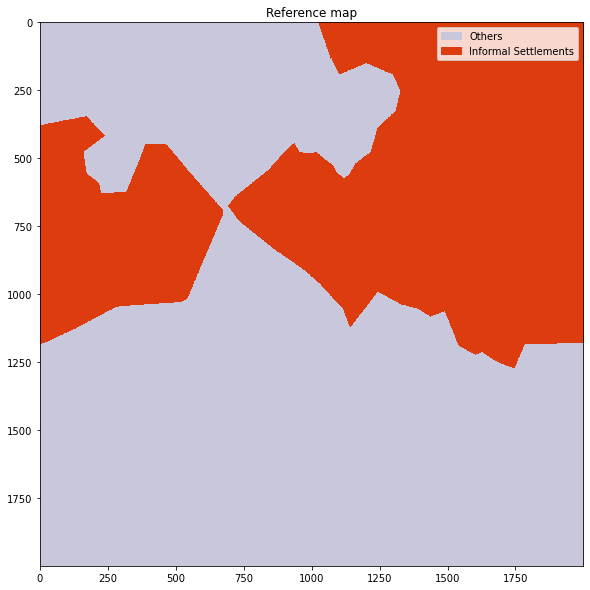

In [51]:
import string
from matplotlib import colors

# set color codes of the classes
_others = [221, 61, 14]
_slums = [200, 199, 219]
ccolors = (_slums, _others)
NROWS, NCOLS, NBANDS = Xtest.shape


def print_map(predictions, idxarray, filename=None, title=None, ccolors=None):
    """Print the classified map.

    Keyword arguments:
    predictions -- the array output labels from the classification
    results
    idxarray -- the array of indices of the classified samples
    to be plotted.
    filename -- the name (with the directory) of the file where to
    write the map.
    ccolors -- an array of tuples containing rgb values for the classes
    Both arrays should match and be arranged accordingly. And the
    index of the color should match the value of the of prediction.
    """
    if predictions.size != idxarray.shape[0]:
        raise ValueError("There should be the same number of " +
                         "predictions and indices.")
    nrows, ncols = np.max(idxarray[:, 0])+1, np.max(idxarray[:, 1])+1
    classifiedmap = np.zeros((nrows, ncols, 3), dtype="uint8")
    idx = 0
    for prediction in predictions:
        classifiedmap[idxarray[idx, 0],
                      idxarray[idx, 1]] = np.asarray(ccolors[prediction])
        idx += 1
    if filename is None:
        fig = plt.figure()
        plt.imshow(classifiedmap)
        if title:
            plt.suptitle(title)
        plt.show()
    else:
        output_raster = gdal.GetDriverByName('GTiff').Create(filename,
                                                             NCOLS,
                                                             NROWS,
                                                             NUMBER_CLASSES,
                                                             gdal.GDT_Byte)
        for i in range(NUMBER_CLASSES):
            output_raster.GetRasterBand(i+1).WriteArray(classifiedmap.astype(np.uint8)[:, :, i])


def get_confusion_matrix(predictions, labels):
    """Compute the confusion matrix.

    Keyword arguments:
    prediction -- the array output labels from the classification
    results
    labels -- the  array of "true" labels from the test set
    Both arrays should match, be arranged accordingly, and
    have non-negative values.
    """
    classes = np.unique(labels)
    nbclasses = classes.size
    if labels.size != predictions.size:
        raise ValueError("There should be the same number of " +
                         "predictions and labels.")
    merged = np.concatenate((predictions.reshape(predictions.size, 1),
                             labels.reshape(labels.size, 1)), axis=1)
    CM = np.zeros((classes[-1] + 1, classes[-1] + 1))
    for c1 in classes:
        for c2 in classes:
            CM[c1, c2] = np.sum(np.logical_and(merged[:, 1] == c1,
                                               merged[:, 0] == c2))
    return CM


def cartesian(arrays, out=None):
    """Utility function to create cartesian image coordinates."""
    arrays = [np.asarray(x) for x in arrays]
    dtype = arrays[0].dtype
    n = np.prod([x.size for x in arrays])
    if out is None:
        out = np.zeros([n, len(arrays)], dtype=dtype)
    m = int(n / arrays[0].size)
    out[:, 0] = np.repeat(arrays[0], m)
    if arrays[1:]:
        cartesian(arrays[1:], out=out[0:m, 1:])
        for j in range(1, arrays[0].size):
            out[j*m:(j+1)*m, 1:] = out[0:m, 1:]
    return out


# plot reference map
norm_ccolors = np.array(ccolors)/255.0
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(1, 1, 1)
cmap = colors.ListedColormap(norm_ccolors)
bounds=[0,1,2]
norm = colors.BoundaryNorm(bounds, cmap.N)
labels = Ytest[:, :, 0].copy()
labels[labels!=2] = 0
labels[labels==2] = 1
ax.imshow(labels, cmap=cmap, norm=norm, interpolation="nearest", origin="upper")
ax.set_title("Reference map")
rectangles = [matplotlib.patches.Rectangle((0, 0), 1, 1, color=norm_ccolors[r]) for r in range(norm_ccolors.shape[0])]
classes = ["Others", "Informal Settlements"]
#Create legend from custom artist/label lists
ax.legend(rectangles, classes)
plt.show()
labels = labels.astype("uint8")

Accuracy metrics of FCN-DK6 results
Overall Accuracy: 0.850169
PA of others: 0.981197
PA of informal settlements: 0.622600


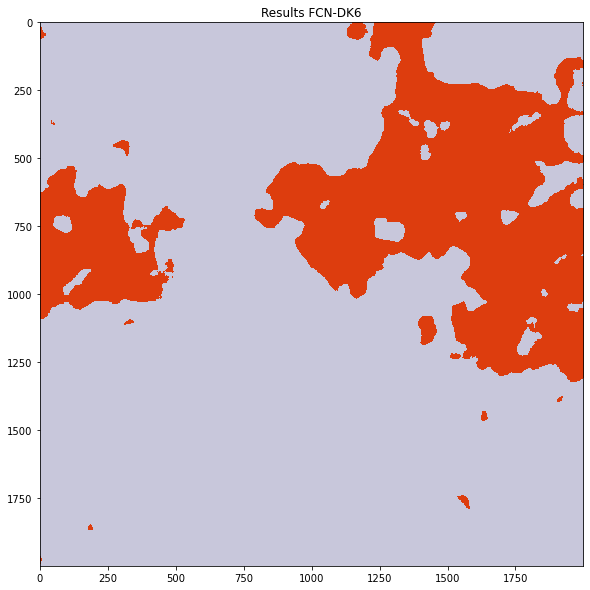

In [52]:
# evaluate FCN-DK6
predictions = predictions_FCNDK6
mapidx = cartesian([range(predictions.shape[0]), range(predictions.shape[1])])
CM = get_confusion_matrix(predictions, labels)
OA = np.sum(np.diag(CM))/predictions.size
PA_bldg = ((predictions[labels==0]==labels[labels==0]).sum())/(labels[labels==0].size)
PA_rd = ((predictions[labels==1]==labels[labels==1]).sum())/(labels[labels==1].size)
mapfname = "map_FCN_DK6.tif"
print("Accuracy metrics of FCN-DK6 results")
print("Overall Accuracy: %f" % OA)
print("PA of others: %f" % PA_bldg)
print("PA of informal settlements: %f" % PA_rd)
predictions_ = predictions.flatten()
print_map(predictions_, mapidx, ccolors=ccolors, filename=mapfname)
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(1, 1, 1)
ax.imshow(predictions, cmap=cmap, norm=norm, interpolation="nearest", origin="upper")
ax.set_title("Results FCN-DK6")
plt.show()